# RoBERTa-large
https://huggingface.co/FacebookAI/xlm-roberta-base

In [1]:
!nvidia-smi

Sun Mar  2 16:33:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:02:00.0 Off |                   On |
| N/A   34C    P0             101W / 300W |  12080MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

|  0    7   0   0  |              12MiB /  9728MiB  | 14      0 |  1   0    0    0    0 |
|                  |               0MiB / 16383MiB  |           |                       |
+------------------+--------------------------------+-----------+-----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+


In [2]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import logging

# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [4]:
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List
from datetime import datetime
import pickle

/vol/venv/rk1121/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load RoBERTa-large

In [9]:
# Load tokenizer and model
MODEL_NAME = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

raw_dir = "models/raw"
model.save_pretrained(raw_dir)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load raw text data

In [5]:
def convert_to_binary(label: Any) -> int:
    """
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """
    # If label_array is a string, convert it to a list
    return 0 if label == 0 or label == 1 else 1 

In [6]:
TRAIN_DATA_PATH = "data/dontpatronizeme_pcl.tsv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t", header=None, names=column_names)
text_data["label"] = text_data["orig_label"].apply(convert_to_binary)

print("Text Data shape:", text_data.shape)

Text Data shape: (10469, 7)


### (Pre-)Tokenize Dataset

In [7]:
def tokenize(text, tokenizer, max_length=128):
  return tokenizer(
    str(text),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )

In [10]:
pretokenized_data = []
for index, row in text_data.iterrows():
  tokenized = tokenize(row["text"], tokenizer)
  tokenized = { key : value.squeeze(0).clone() for key, value in tokenized.items() }
  tokenized["labels"] = row["label"]
  pretokenized_data.append(tokenized)

with open("pretokenized.pkl", "wb") as f:
  pickle.dump(pretokenized_data, f)

### Load into DataLoader's

In [19]:
class DontPatronizeMeDataset(Dataset):
  def __init__(self, data, tokenizer = None, max_length=128):
    self.tokenizer = tokenizer

    if self.tokenizer is not None:
      self.max_length = max_length
      self.data = data.reset_index(drop = True)
    else:
      self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    if self.tokenizer is not None:
      text = str(self.data.loc[idx, "text"])
      label = self.data.loc[idx, "label"]

      encoding = self.tokenizer(
        text, 
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
      )

      encoding = { key: value.squeeze(0) for key, value in encoding.items() }
      encoding["labels"] = torch.tensor(label, dtype=torch.long)

      return encoding
    else:
      return self.data[idx]


In [38]:
with open("pretokenized.pkl", "rb") as f:
  pretokenized_data = pickle.load(f)

labels = [int(item["labels"]) for item in pretokenized_data]

train_data, test_data = train_test_split(
  pretokenized_data,
  test_size = 0.2,
  random_state = 16,
  stratify=labels
)

train_dataset = DontPatronizeMeDataset(train_data)
test_dataset = DontPatronizeMeDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Data Visualisation

### See if there is class imabalance

--- Train ---
{0: 7581, 1: 794}
{0: '90.52%', 1: '9.48%'}
--- Test ---
{0: 1895, 1: 199}
{0: '90.50%', 1: '9.50%'}


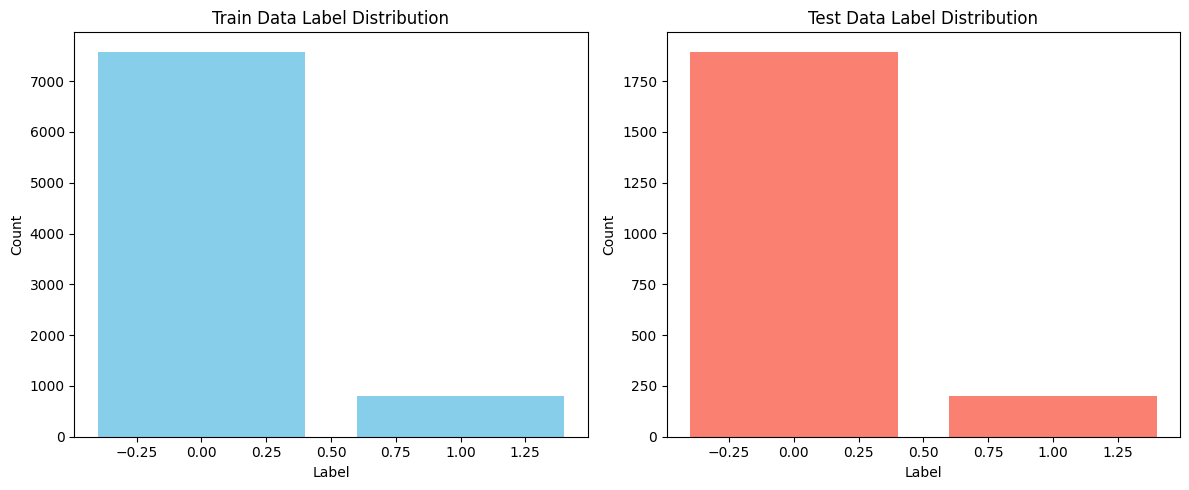

In [52]:
import matplotlib.pyplot as plt
from collections import Counter

train_labels = [int(item["labels"]) for item in train_data]
test_labels = [int(item["labels"]) for item in test_data]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

train_sorted = { k : v for k, v in sorted(train_counts.items()) }
test_sorted = { k : v for k, v in sorted(test_counts.items()) }

print("--- Train ---")
print(train_sorted)
train_total = sum(train_counts.values())
print({ k: f"{(100 * v / train_total):.2f}%" for k, v in train_sorted.items() })

print("--- Test ---")
print(test_sorted)
test_total = sum(test_counts.values())
print({ k: f"{(100 * v / test_total):.2f}%" for k, v in test_sorted.items() })

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].bar(list(train_sorted.keys()), list(train_sorted.values()), color='skyblue')
axes[0].set_title('Train Data Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

axes[1].bar(list(test_sorted.keys()), list(test_sorted.values()), color='salmon')
axes[1].set_title('Test Data Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Baseline Evaluation

In [43]:
def predict(model, loader: DataLoader, save_path: str = None):
  model.eval()

  predictions = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(inputs, attention_mask=attention_mask)
      logits = outputs.logits

      preds = torch.argmax(logits, dim=1)
      predictions.extend(preds.cpu().numpy().tolist())
  
  if save_path is not None:
    with open(save_path, "w") as f:
      for prediction in predictions:
        f.write(f"{prediction}\n")

  return predictions

In [44]:
def evaluate(model, loader: DataLoader):
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
      for batch in loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(inputs, attention_mask=attention_mask)
          logits = outputs.logits

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.cpu().numpy().tolist())
          y_pred.extend(predictions.cpu().numpy().tolist())

  # # Convert to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average="macro")

  # predictions, labels = predict(model, loader=loader, with_labels=True, save_path=save_path)

  # Compute metrics
  # accuracy = accuracy_score(labels, predictions)
  # f1 = f1_score(labels, predictions, average="macro")

  return accuracy, f1

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: 0.101242
# F1:  0.094094
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Test Accuracy: 0.095033
Test F1 Score: 0.086786


### Fine-tune the model 

In [36]:
from torch.amp import autocast, GradScaler

def finetune(
  model, 
  loader: DataLoader, 
  num_epochs: int = 10, 
  lr: float = 2e-5, 
  patience: int = 2
):

  best_val_loss = float("inf")
  epochs_no_improv = 0

  optimiser = optim.AdamW(model.parameters(), lr=lr)
  total_steps = len(loader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(
    optimiser, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
  )

  scaler = GradScaler(device="cuda")

  timestamp = datetime.now().strftime("%H:%M:%S")
  print(f"{timestamp} - num_epochs = {num_epochs} | lr = {lr} | patience = {patience}")

  for epoch in range(num_epochs):
    model.train()
    total_loss: float = 0.0

    for batch in loader:
      optimiser.zero_grad()

      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # Use `autocast` for mixed precision forward pass
      with autocast(device_type="cuda"):
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

      scaler.scale(loss).backward()
      scaler.step(optimiser)
      scheduler.step()
      scaler.update()

      total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
      for batch in loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast(device_type="cuda"):
          outputs = model(inputs, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(loader)

    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"{timestamp} - Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_loss:.6f} | Validation Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improv = 0
      best_model_state = model.state_dict()

    else:
      epochs_no_improv += 1
      if epochs_no_improv >= patience:
        print(f"Stopping at epoch {epoch}...")
        break
    
  model.load_state_dict(best_model_state)

In [39]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 5min per epoch
finetune(model, train_loader, num_epochs = 10)

basic_finetuned_dir = "models/basic_finetuned"
model.save_pretrained(basic_finetuned_dir)

17:27:15 - num_epochs = 10 | lr = 2e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


17:31:18 - Epoch 1/10 | Train Loss: 0.307378 | Validation Loss: 0.215937
17:35:23 - Epoch 2/10 | Train Loss: 0.209410 | Validation Loss: 0.122734
17:39:28 - Epoch 3/10 | Train Loss: 0.141320 | Validation Loss: 0.069844
17:43:32 - Epoch 4/10 | Train Loss: 0.071849 | Validation Loss: 0.014653
17:47:37 - Epoch 5/10 | Train Loss: 0.032062 | Validation Loss: 0.010461
17:51:42 - Epoch 6/10 | Train Loss: 0.019765 | Validation Loss: 0.005185
17:55:47 - Epoch 7/10 | Train Loss: 0.010363 | Validation Loss: 0.002446
17:59:52 - Epoch 8/10 | Train Loss: 0.004966 | Validation Loss: 0.000759
18:03:57 - Epoch 9/10 | Train Loss: 0.002219 | Validation Loss: 0.000318
18:08:02 - Epoch 10/10 | Train Loss: 0.001054 | Validation Loss: 0.000296


### Evaluate the model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(basic_finetuned_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: 0.923591
# F1:  0.754404
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Test Accuracy: 0.923591
Test F1 Score: 0.754404


### Load test data

In [ ]:
TEST_DATA_PATH = "data/task4_test.tsv"

column_names = ["par_id", "art_id", "keyword", "country", "text"]
test_data = pd.read_csv(TEST_DATA_PATH, sep="\t", header=None, names=column_names)

print("Test Data shape:", test_data.shape)

# print(test_text_data.head())

test_dataset = DontPatronizeMeDataset(test_data, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


Test Data shape: (3832, 5)


In [32]:
full_dev_dataset = DontPatronizeMeDataset(text_data, tokenizer, max_length=128)
full_dev_loader = DataLoader(full_dev_dataset, batch_size=16, shuffle=False, num_workers=4)

In [35]:
model = RobertaForSequenceClassification.from_pretrained(basic_finetuned_dir).to(device)

print("Generating predictions for Dev...")
predict(model, full_dev_loader, save_path="dev.txt")

print("Generating predictions for Test...")
predict(model, test_loader, save_path="test.txt")


Generating predictions for Dev...
Generating predictions for Test...


[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
